In [1]:
# imports
from inspect import signature
import control
import numpy
from matplotlib import pyplot as plt

In [2]:
# inputs
def step(t, start, stop):
    if t<start:
        return 0
    else:
        return 1
    #     return numpy.concatenate((numpy.array([0 for i in range(s)]), numpy.array([1 for i in range(l)])), axis=None)


def rect(t, start, drop, stop):
    if t>=start and t<stop:
        return 1
    else:
        return 0
    #     return numpy.concatenate((numpy.array([0 for i in range(s)]), numpy.array([1 for i in range(l)]), numpy.array([0 for i in range(f)])), axis=None)


def doublet(t, start, drop, rise, stop):
    if t>=start and t<drop:
        return 1
    elif t>=drop and t<stop:
        return -1
    else:
        return 0
    #     return numpy.concatenate((numpy.array([0 for i in range(s)]), numpy.array([1 for i in range(l1)]), numpy.array([-1 for i in range(l2)]), numpy.array([0 for i in range(f)])), axis=None)
    
input_dict = {'step': step, 
              'rect': rect, 
              'doublet': doublet}

In [3]:
# read data
def read(file):
    df = pandas.read_csv(file)
    ydata = df.y.values - df.y[0]
    udata = df.u.values - df.u[0]
    tdata = df.t.values
    return [ydata, udata, tdata]

In [11]:
# system

# def FO(u, mv, uv, l):
#     K, tau = mv
#     ts = numpy.linspace(0,l)
#     dt = ts[1]
#     y = 0
#     ys = []
#     for t in ts:
#         dydt = -1/tau*y + 1/tau*u(t, up)
#         y += dydt*dt
#         ys.append(y)
#     return ys

def FO(K, τ):
    return control.tf(K, [τ, 1])

def create_system(num, den):
    return control.tf(num, den)
    
    
    
# -convert to statespace and integrate

system_dict = {'First Order': FO,
              'Create System': create_system}

In [24]:
def params(u, i):
    sig = str(signature(u)).split(', ')
    sig[0] = sig[0].split('(')[-1]
    sig[-1] = sig[-1].split(')')[0]
    return sig[i:]
    
def ui():
    names = [names for names,dict in input_dict.items()]
    c_input = input("Choose an input type from: {}".format(names))
#     if c_input not in names:
#         while c_input not in names:
#             c_input = input("Ivalid input. Choose an input type from: {}".format(names))
    u = input_dict[c_input]
    u_sig = params(u,1)
    c_input_params = [float(i) for i in input("Input paramter list of format: {}".format(u_sig)).split(', ')]
    
    names = [names for names,dict in system_dict.items()]
    c_system = input("Choose a system type from: {}".format(names))
    sys = system_dict[c_system]
    sys_sig = params(sys,0)
    c_sys_params = [float(i) for i in input("numerator").split(', ')], [float(i) for i in input("denominator").split(', ')]
    print(*c_sys_params)
#     c_sys_params = [float(i) for i in (input("Input paramter list of format: {}".format(sys_sig))).split(', ')]

    ts = numpy.linspace(0, c_input_params[-1])
    system = create_system(*c_sys_params)
    t, y, x = control.forced_response(system, T=ts, U=[u(t, *c_input_params) for t in ts])
    plt.plot(t, y)
    
    

Choose an input type from: ['step', 'rect', 'doublet'] step
Input paramter list of format: ['start', 'stop'] 10, 100
Choose a system type from: ['First Order', 'Create System'] Create System
numerator 10
denominator 10, 1


[10.0] [10.0, 1.0]


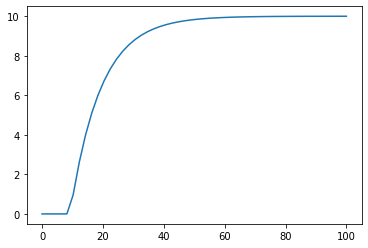

In [25]:
ui()

In [8]:
st = "1, 2"
st.split("]")[0].split("[")[-1].split(", "), st.split("[")[-1].split("]")[0].split(", ")
# [float(i) for i in "[1, 2], [3. 4]".split(', ')]
# str.split("[")[-1].split("]")

"['10', '2']".split("'")

['[', '10', ', ', '2', ']']

In [13]:
x = control.tf(1, [1,1])

In [ ]:
x.